# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [ ]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/datasets/real_estate_data.csv", sep = '\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [ ]:
# Оценим объем пропущенных значений в данных

(100. * df.loc[:, df.isna().any()].isna().sum()/df.shape[0]).round(1).astype(str) + '%'

ceiling_height         38.8%
floors_total            0.4%
living_area             8.0%
is_apartment           88.3%
kitchen_area            9.6%
balcony                48.6%
locality_name           0.2%
airports_nearest       23.4%
cityCenters_nearest    23.3%
parks_around3000       23.3%
parks_nearest          65.9%
ponds_around3000       23.3%
ponds_nearest          61.6%
days_exposition        13.4%
dtype: object

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [ ]:
#Проверим данные на дубликаты

df.duplicated().sum()

0

### Вывод

В датасете представлены данные о 23699 квартирах по 22 параметрам. В некоторых столбцах пропущено большое количество значений (до 88,3%) как предоставленных пользователями, так и сгенерированых автоматически. Полных дубликатов нет.
Сразу можно отметить некоторые аномалии в данных:
* Квартиры с нулевым количеством комнат
* Высота потолков 1м и 100м
* Жилая площадь 2м.кв.
* Площадь кухни 112м.кв.
* Расстояние до аэропорта 0м


### Предобработка данных

Рассмотрим по каким причинам могли появиться пропущенные значения.
Логично предположить, что NaN в столбце "balcony" означает отсутствие балкона в квартире, поэтому мы можем здесь заменить пропущенные значения на ноль.

In [ ]:
df['balcony'] = df['balcony'].fillna(0)

Пропущенные значения в колонке 'is_apartment' так же скорее всего связаны с тем, что люди не отмечали этот пункт в анкете, предполагая, что для жилых помещений (квартир) это значение не нужно. 
Заменим NaN на False, что одновременно изменит тип данных на bool.

In [ ]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'].dtype

dtype('bool')

Рассмотрим столбец 'ceiling_height', в котором пропущено почти 40%. 

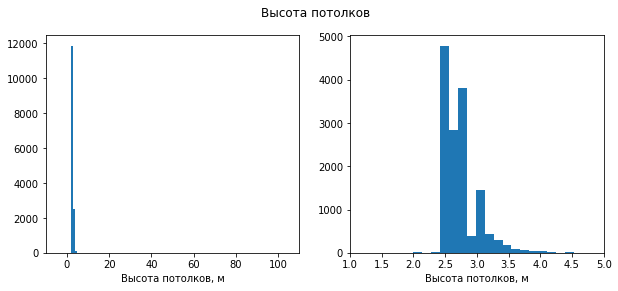

In [ ]:
_, axs = plt.subplots(1, 2, figsize = (10,4))


axs[0].set(xlim=(-10, 110), xlabel = 'Высота потолков, м')
axs[0].hist(df['ceiling_height'], bins = 100)
axs[1].set(xlim=(1, 5), xlabel = 'Высота потолков, м')
axs[1].hist(df['ceiling_height'], bins = 700)
#plt.tight_layout()
plt.suptitle('Высота потолков')
plt.show()

Основная часть значений лежит в диапазоне 2,2 - 3,2 м, но есть и достаточно большие выбросы в районе 20м, и даже одна квартира с высотой потолков 100м (явная ошибка). Мы можем заменить NaN в этом столбце на медианное значение, которое не зависит от статистических выбросов, но стоит сохранить в отдельной колонке информацию о том, было ли это значение изменено нами или высота потолков в квартире изначально равнялась медианному значению. 

In [ ]:
ceiling_median = df['ceiling_height'].median()

In [ ]:
print('Количество квартир с высотой потолков, равной медианной :',df[df['ceiling_height'] == ceiling_median]['ceiling_height'].count())

Количество квартир с высотой потолков, равной медианной : 676


In [ ]:
df['ceiling_to_median'] = df['ceiling_height'].isna()
print('Количество квартир с измененной высотой потолков :',df['ceiling_to_median'].sum())

Количество квартир с измененной высотой потолков : 9195


In [ ]:
df['ceiling_height'] = df['ceiling_height'].fillna(ceiling_median)

Изучим столбцы 'living_area' и 'kitchen_area'. В них пропущено соответственно 8% и 9,6% значений. 

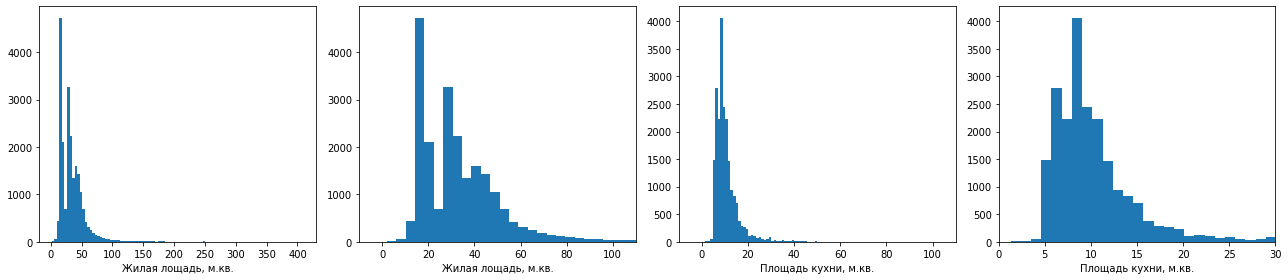

In [ ]:
_, axs = plt.subplots(1, 4, figsize = (18,4))

axs[0].set(xlabel = 'Жилая лощадь, м.кв.')
axs[0].hist(df['living_area'], bins = 100)
axs[1].set(xlim=(-10, 110), xlabel  = 'Жилая лощадь, м.кв.')
axs[1].hist(df['living_area'], bins = 100)
axs[2].set(xlim=(-10, 110) , xlabel  = 'Площадь кухни, м.кв.')
axs[2].hist(df['kitchen_area'], bins = 100)
axs[3].set(xlim=(0, 30), xlabel  = 'Площадь кухни, м.кв.')
axs[3].hist(df['kitchen_area'], bins = 100)
plt.tight_layout()
plt.show()

In [ ]:
print('Количество пропущенных значений "kitchen_area" :', df['kitchen_area'].isnull().sum())
print('Количество пропущенных значений одновременно в "kitchen_area" и "living_area" :', df['living_area'][df['kitchen_area'].isnull()].isnull().sum())

Количество пропущенных значений "kitchen_area" : 2278
Количество пропущенных значений одновременно в "kitchen_area" и "living_area" : 1464


Видим, что в обоих столбцах распределение далеко от нормального, имеются несколько мод на гистограмме и большие выбросы.
Это не позволяет нам заменить NaN на характерные значения в этих столбцах. При этом в 1464 строках из 2278 пропуски содержатся в обоих столбцах. Для дальнейшего анализа мы можем найти медианные значения соотношения kitchen_area к total_area и  и заменить пропущенные значения на рассчитанные из известной total_area. 
Пропуски в этих строках появились скорее всего из-за неполного заполнения данных клиентами.

In [ ]:
kitchen_ratio_median = (df["kitchen_area"]/df["total_area"]).median()
living_ratio_median = (df["living_area"]/df["total_area"]).median()
print('Медиана kitchen_area/total_area = {:.2f}'.format(kitchen_ratio_median))
print('Медиана living_area/total_area = {:.2f}'.format(living_ratio_median))

Медиана kitchen_area/total_area = 0.17
Медиана living_area/total_area = 0.57


In [ ]:
# Заменяем NaN на расчетные значения. Для дальнейшего анализа создадим столбец с информацией где 'kitchen_area' рассчитана
df['kitchen_to_median'] = df['kitchen_area'].isna()
df['kitchen_area'] = df['kitchen_area'].fillna(df["total_area"]*kitchen_ratio_median)
df['living_area'] = df['living_area'].fillna(df["total_area"]*living_ratio_median)

Рассмотрим столбцы со сгенерированными данными: 

    - airports_nearest        23.4%
    - cityCenters_nearest     23.3%
    - parks_around3000        23.3%
    - parks_nearest           65.9%
    - ponds_around3000        23.3%
    - ponds_nearest           61.6%

Пропущенные значения вероятно обусловлены особенностью работы алгоритма, расчитывающего эти значения. 
Возможно, для получения этих данных требовались координаты объекта, но они были пропущены или потеряны.
Проверим взаимосвязь этих данных на примере столбцов "cityCenters_nearest", "ponds_around3000" и "parks_around3000".

In [ ]:
print('Количество пропущенных значений "ponds_around3000" :', df['ponds_around3000'].isnull().sum())
print('Количество пропущенных значений одновременно в "cityCenters_nearest" и "ponds_around3000" :', df['cityCenters_nearest'][df['ponds_around3000'].isnull()].isnull().sum())
print('Количество пропущенных значений одновременно в "parks_around3000" и "ponds_nearest" :', df['parks_around3000'][df['ponds_nearest'].isnull()].isnull().sum())

Количество пропущенных значений "ponds_around3000" : 5518
Количество пропущенных значений одновременно в "cityCenters_nearest" и "ponds_around3000" : 5518
Количество пропущенных значений одновременно в "parks_around3000" и "ponds_nearest" : 5518


Как мы видим, пропуски в разных столбцах встречаются одновременно.
При этом в столбцах "parks_nearest" и "ponds_nearest" значительно больше пропусков. Вероятно, это связано с тем, что помимо пропущенных значений координат есть некоторые предельные значения расстояний до парка или водоема, выше которых считается, что значения не имеют смысла.

In [ ]:
print('Максимальное значение "parks_nearest" :', df['parks_nearest'].max())
print('Максимальное значение "ponds_nearest" :', df['ponds_nearest'].max())

Максимальное значение "parks_nearest" : 3190.0
Максимальное значение "ponds_nearest" : 1344.0


В таком случае, можно заменить NaN, встречающиеся только в столбцах "parks_nearest" и "ponds_nearest" на условные значения, превышающие максимальные.

In [ ]:
df.loc[((~df['ponds_around3000'].isnull()) & (df['parks_nearest'].isnull())),['parks_nearest']] = 5000
df.loc[((~df['ponds_around3000'].isnull()) & (df['ponds_nearest'].isnull())),['ponds_nearest']] = 2000

В столбце "days_exposition" пропущенные значения могут означать, что на момент выгрузки базы, объявление было еще актуально, т.е. квартиру еще не продали. 
Тогда мы можем найти объявление, опубликованное последним и принять эту дату за примерную дату выгрузки базы и из нее расчитать количество дней публикации объявлений. Для этого сначала значения столбца с датой размещения объявления преобразуем к типу DateTime.

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

In [ ]:
recent_ad = df['first_day_exposition'].max()
print('Последняя дата размещения объявления :', recent_ad)

Последняя дата размещения объявления : 2019-05-03 00:00:00


In [ ]:
# Заменяем NaN на рассчитаные значения 

df['days_calculated'] = df['days_exposition'].isna()
df.loc[df['days_exposition'].isnull(),'days_exposition'] = (recent_ad - df['first_day_exposition']).dt.days
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceiling_to_median,kitchen_to_median,days_calculated
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,18863.0,16028.0,1.0,482.0,2.0,755.0,57.0,False,False,True
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,False,...,12817.0,18603.0,0.0,5000.0,0.0,2000.0,81.0,True,False,False
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,False,...,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,True,False,False
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,90.289724,9,False,...,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,True,True,False
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,False,False,False
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,55.0,True,False,False
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,False,...,52996.0,19143.0,0.0,5000.0,0.0,2000.0,155.0,True,False,False
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,40.658769,22,False,...,23982.0,11634.0,0.0,5000.0,0.0,2000.0,15.0,True,False,True
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.430000,26,False,...,NaN,NaN,NaN,NaN,NaN,NaN,189.0,True,False,False
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,False,...,50898.0,15008.0,0.0,5000.0,0.0,2000.0,289.0,False,False,False


Строки с пропущенными значениями в столбцах "floors_total", "locality_name" можем удалить, потмоу что их меньше 1%

In [ ]:
df = df.dropna(subset = ["floors_total", "locality_name"], axis = 0).reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 25 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           18065 non-null float64
ponds_a

Изучим возможность оптимизации пипов данных


In [ ]:
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Средний объем использованной памяти для {} столбцов: {:03.2f} MB".format(dtype,mean_usage_mb))

Средний объем использованной памяти для float столбцов: 0.17 MB
Средний объем использованной памяти для int столбцов: 0.13 MB
Средний объем использованной памяти для object столбцов: 1.24 MB


Приведем данные в следующих столбцах

     - floors_total            float64
     - balcony                 float64
     - airports_nearest        float64
     - cityCenters_nearest     float64
     - parks_around3000        float64
     - parks_nearest           float64
     - ponds_around3000        float64
     - ponds_nearest           float64
     - days_exposition         float64

к типу данных int, т.к. в них должны содержаться целочисленные значения


In [ ]:
columns_list = ['first_day_exposition', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for column in columns_list:
    if df[column].dtype == 'float64':
        try:
            df[column] = df[column].fillna(-1) 
            df[column] = df[column].astype('int64')
        except:
            print('Ошибка формата1')
    elif df[column].dtype == 'object':
        try:
            df[column] = pd.to_datetime(df[column], format = '%Y-%m-%dT%H:%M:%S')
        except:
            print('Ошибка формата2')
    else: pass
df[columns_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 10 columns):
first_day_exposition    23565 non-null datetime64[ns]
floors_total            23565 non-null int64
balcony                 23565 non-null int64
airports_nearest        23565 non-null int64
cityCenters_nearest     23565 non-null int64
parks_around3000        23565 non-null int64
parks_nearest           23565 non-null int64
ponds_around3000        23565 non-null int64
ponds_nearest           23565 non-null int64
days_exposition         23565 non-null int64
dtypes: datetime64[ns](1), int64(9)
memory usage: 1.8 MB


<div class="alert alert-block alert-info">
Оптимизируем ипользование памяти путем изменения подтипа целочисленных данных
</div>

In [ ]:
#Функция расчета используемой памяти

def mem_usage(data):
    usage_b = data.memory_usage(deep=True).sum()
    usage_mb = usage_b / 1024 ** 2 
    return usage_mb.round(2)


df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

df.loc[:, df_int.columns] = converted_int
df.loc[:, df_float.columns] = converted_float

tot_mem_before = mem_usage(df_int) + mem_usage(df_float)
tot_mem_after = mem_usage(converted_int) + mem_usage(converted_float)
reduced_int = (100*(1-mem_usage(converted_int)/ mem_usage(df_int))).round(2)
reduced_float = (100*(1-mem_usage(converted_float)/ mem_usage(df_float))).round(2)
reduced_total = (100*(1-tot_mem_after/tot_mem_before)).round(2)


# print("Использовано памяти до оптимизации int данных:", mem_usage(df_int))
# print("Использовано памяти после оптимизации int данных:", mem_usage(converted_int))
# print()
# print("Использовано памяти до оптимизации float данных:", mem_usage(df_float))
# print("Использовано памяти после оптимизации float данных:", mem_usage(converted_float))

mem_optimized = pd.DataFrame({'dtype' : ['int', 'float', 'total'], 
                             'before, MB' : [mem_usage(df_int), mem_usage(df_float), tot_mem_before], 
                             'after, MB' : [mem_usage(converted_int), mem_usage(converted_float), tot_mem_after],
                             'reduced, %' : [reduced_int, reduced_float, reduced_total]})
mem_optimized

,dtype,"before, MB","after, MB","reduced, %"
0,int,2.16,1.24,42.59
1,float,0.90,0.45,50.00
2,total,3.06,1.69,44.77


<div class="alert alert-block alert-info">
В результате оптимизации подтипов данных удалось снизить использование памяти на 45%
</div>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 25 columns):
total_images            23565 non-null uint8
last_price              23565 non-null float32
total_area              23565 non-null float32
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null uint8
ceiling_height          23565 non-null float32
floors_total            23565 non-null uint8
living_area             23565 non-null float32
floor                   23565 non-null uint8
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float32
balcony                 23565 non-null uint8
locality_name           23565 non-null object
airports_nearest        23565 non-null int64
cityCenters_nearest     23565 non-null int64
parks_around3000        23565 non-null int64
parks_nearest           23565 non-null int64
ponds_around3000   

### Расчет дополнительных параметров

In [ ]:
#Рассчитаем цену квадратного метра квартиры

df['meter_price'] = (df['last_price']/df['total_area']).round(2)

In [ ]:
#Создадим отдельные столбцы с годом, месяцем и днем недели публикации объявления

df['year'] = df['first_day_exposition'].dt.year
df['month'] = df['first_day_exposition'].dt.month
df['weekday'] = df['first_day_exposition'].dt.weekday

In [ ]:
#Проведем категоризацию данных по номеру этажа (1-первый, 2-последний, 3-другой)

def floor_group(floor, floors_total):
    if floor == 1:
        return 1
    elif floor == floors_total:
        return 2
    return 3
df['floor_group'] = df.apply(lambda x: floor_group(x['floor'], x['floors_total']), axis=1)

In [ ]:
#Посчитаем и добавим в датасет отношение жилой к общей площади, а также отношение площади кухни к общей

df['living_total_ratio'] = df['living_area']/df['total_area']
df['kitchen_total_ratio'] = df['kitchen_area']/df['total_area']

### Исследовательский анализ данных

Изучим данные по параметрам: площадь, цена, число комнат, высота потолков, жилая площадь, срок публикации, этаж.

In [ ]:
# Напишем функцию для автоматизации анализа

def analyze_param(parameter, bins1 = 600, bins2 = 500):
    
    mean = np.round(np.mean(df[parameter]), 2)
    median = np.round(np.median(df[parameter]), 2)
    mode = np.array(df[parameter].value_counts().iloc[:3].index)
    min_value = np.round(df[parameter].min(), 2)
    max_value = np.round(df[parameter].max(), 2)
    Q0_01 = np.round(df[parameter].quantile(0.01), 2)
    Q1 = np.round(df[parameter].quantile(0.25), 2)
    Q3 = np.round(df[parameter].quantile(0.75), 2)
    Q0_99 = np.round(df[parameter].quantile(0.99), 2)
    iqr = np.round(Q3 - Q1, 2) # Interquartile range
    
    _, axs = plt.subplots(1, 4, figsize = (18,6))
    axs[0].set(ylabel = parameter)
    axs[0].boxplot(df[parameter])
    axs[1].set(ylim=(Q1-2*iqr, Q3+3*iqr),ylabel = parameter)
    axs[1].boxplot(df[parameter])
    axs[2].hist(df[parameter], bins = bins1)
    axs[3].set(xlim=(Q1-2*iqr, Q3+3*iqr))
    axs[3].hist(df[parameter], bins = bins2)
    plt.tight_layout(pad=4, w_pad=2, h_pad=1.0)
    plt.suptitle(parameter)
    plt.show()
    
    print('Min: {:.2f}'.format(min_value))
    print('Mean: {:.2f}'.format(mean))
    print('Max: {:.2f}'.format(max_value))
    print('Mode: {}'.format(mode))
    print('1st percentile: {:.2f}'.format(Q0_01)) 
    print('25th percentile: {:.2f}'.format(Q1))
    print('Median: {:.2f}'.format(median))
    print('75th percentile: {:.2f}'.format(Q3))
    print('99th percentile: {:.2f}'.format(Q0_99))
    print('Interquartile range (IQR): {:.2f}'.format(iqr))

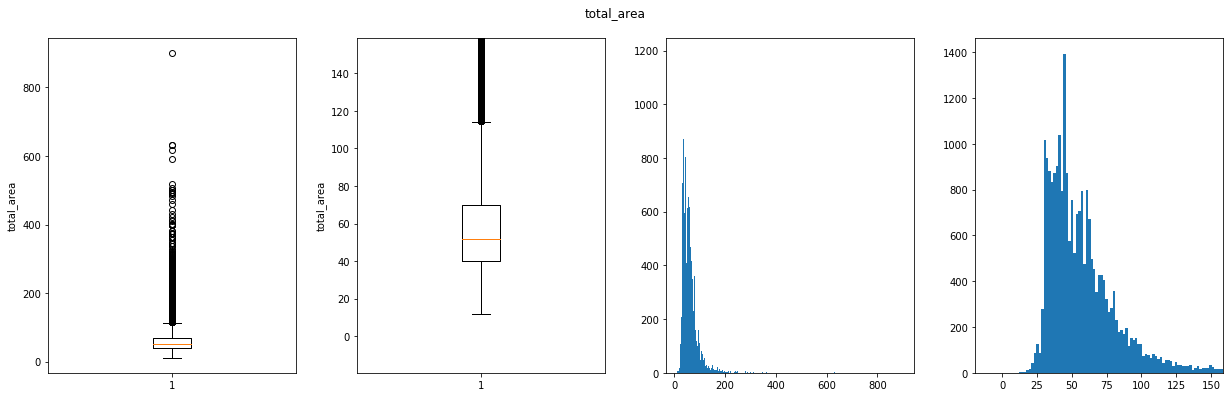

Min: 12.00
Mean: 60.32
Max: 900.00
Mode: [45. 42. 60.]
1st percentile: 25.32
25th percentile: 40.00
Median: 52.00
75th percentile: 69.70
99th percentile: 197.45
Interquartile range (IQR): 29.70


In [ ]:
# Анализ 'total_area'

analyze_param('total_area')

Значения общей площади распределены преимущественно в диапазоне 25 - 197 м.кв. со средним значением 60,32м.кв. и медианным 52м.кв.. Распределение сдвинуто влево. Есть выбросы с очень большими значениями (около 600м.кв. и 900м.кв.) и очень маленьким (12 м.кв.) удалим их.

In [ ]:
df = df.drop(df[df['total_area'] >= 500].index).reset_index(drop = True)
df = df.drop(df[df['total_area'] <= 20].index).reset_index(drop = True)

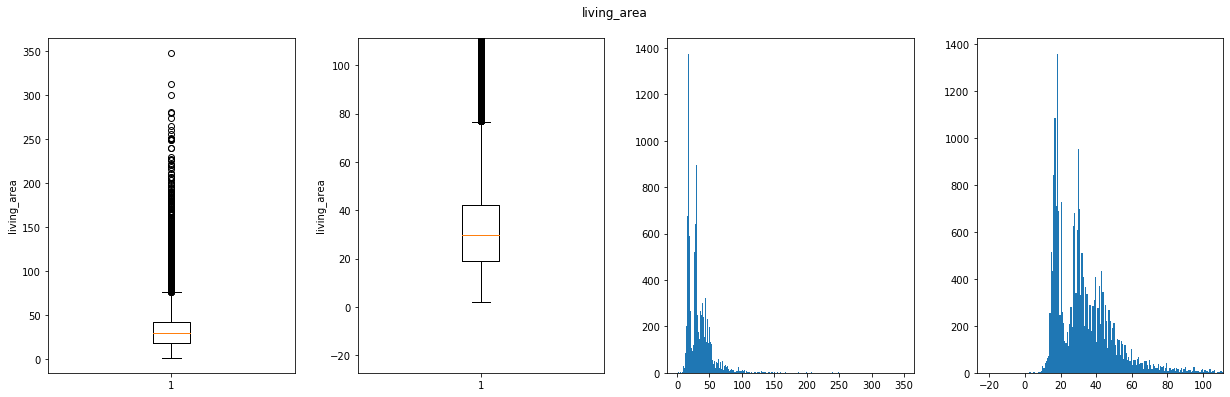

Min: 2.00
Mean: 34.50
Max: 347.50
Mode: [18. 17. 30.]
1st percentile: 13.10
25th percentile: 19.00
Median: 30.00
75th percentile: 42.10
99th percentile: 119.98
Interquartile range (IQR): 23.10


In [ ]:
# Анализ 'living_area'

analyze_param('living_area')

Значения жилой площади распределены преимущественно в диапазоне 13 - 120 м.кв. со средним значением 34,5м.кв. и медианным 30м.кв.. Распределение сдвинуто влево и имеет выраженные моды (примерно 18м.кв и 30м.кв). Есть выбросы с очень большими значениями (около 300м.кв.) и очень маленьким (2м.кв). Удалим их

In [ ]:
df = df.drop(df[df['living_area'] >= 300].index).reset_index(drop = True)
df = df.drop(df[df['living_area'] <= 10].index).reset_index(drop = True)

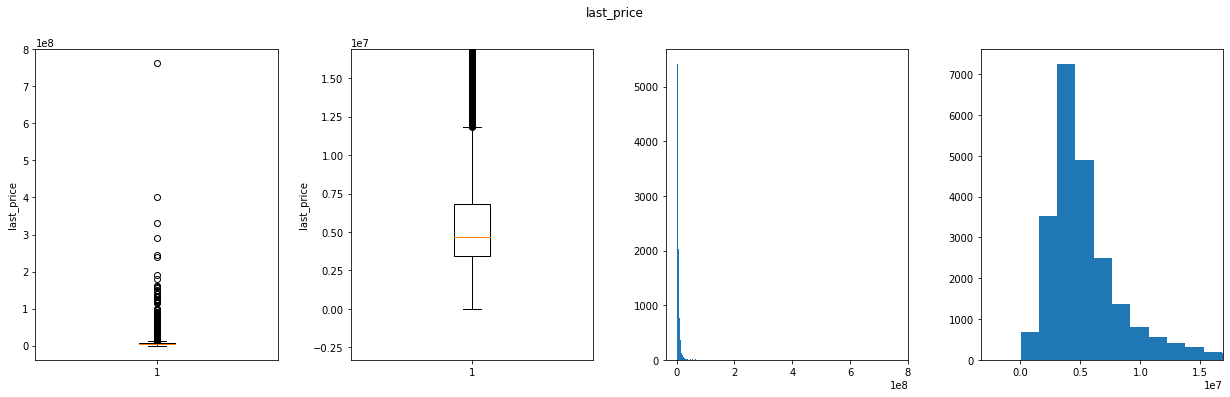

Min: 12190.00
Mean: 6477248.50
Max: 763000000.00
Mode: [4500000. 3500000. 4300000.]
1st percentile: 1000000.00
25th percentile: 3430000.00
Median: 4650000.00
75th percentile: 6800000.00
99th percentile: 35000000.00
Interquartile range (IQR): 3370000.00


In [ ]:
# Анализ 'last_price'

analyze_param('last_price')

Значения цены распределены преимущественно в диапазоне 1млн - 35млн. со средним значением 6,5млн. и медианным 4,6млн. Распределение сдвинуто влево и имеет выраженные моды (3,5млн., 4млн. и 4,5млн.). Есть выбросы с очень большими значениями (около 300 - 400млн. и 763млн), а так же очень маленьким (0,012млн.). Удалим их.

In [ ]:
df = df.drop(df[df['last_price'] >= 5e8].index).reset_index(drop = True)
df = df.drop(df[df['last_price'] <= 1e5].index).reset_index(drop = True)

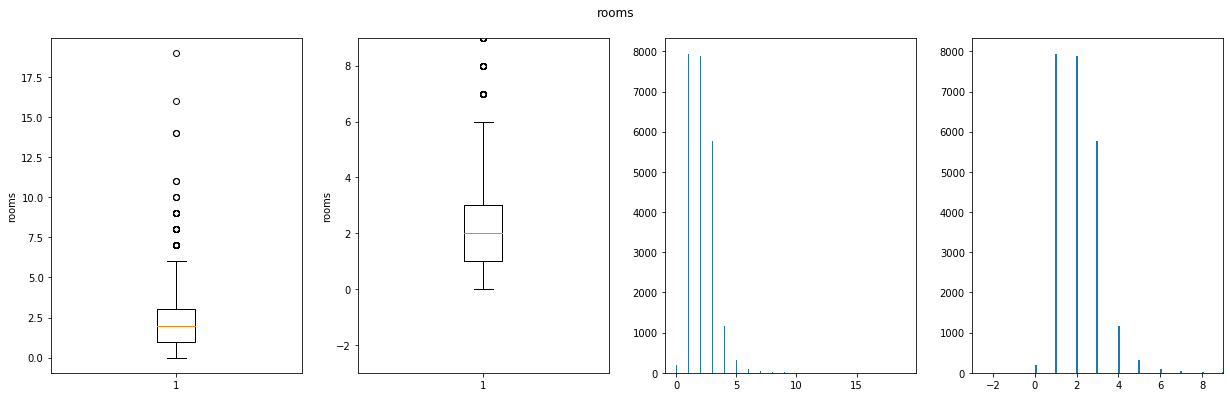

Min: 0.00
Mean: 2.07
Max: 19.00
Mode: [1 2 3]
1st percentile: 1.00
25th percentile: 1.00
Median: 2.00
75th percentile: 3.00
99th percentile: 5.00
Interquartile range (IQR): 2.00


In [ ]:
# Анализ 'rooms'

analyze_param('rooms', bins1 = 200, bins2 = 200)

Значения количества комнат распределены преимущественно в диапазоне 1 - 5 со средним значением 2,07 и медианным 2. Есть выбросы с очень большими значениями (около 15, 19) и непонятным нулевым значением. Скорее всего, это квартиры-студии где нет отдельных комнат. Проверим эту гипотезу, изучив другие параметры квартир с 0 комнат.

In [ ]:
df.query("rooms == 0")[['total_area', 'kitchen_area', 'studio', 'open_plan', 'kitchen_to_median']]

,total_area,kitchen_area,studio,open_plan,kitchen_to_median
143,27.000000,4.655172,True,False,True
345,25.000000,4.310345,False,True,True
436,27.110001,4.674138,True,False,True
503,34.400002,5.931035,False,True,True
603,25.000000,4.310345,True,False,True
...,...,...,...,...,...
22981,26.000000,4.482759,True,False,True
23211,27.700001,4.775862,False,True,True
23323,26.000000,4.482759,True,False,True
23359,29.000000,5.000000,False,True,True


In [ ]:
# Проверим есть ли среди них квартиры с отдельной кухней

df.query("rooms == 0 & (studio == True | open_plan == True)")['last_price'].count()

182

Всё это квартиры-студии или квартиры со свободной планировкой, у которых площадь кухни расчитана нами ранее из общей площади. Учтем это в дальнейшем анализе. 

In [ ]:
# Удалим выбросы по количеству комнат

df = df.drop(df[df['rooms'] >= 12].index).reset_index(drop = True)

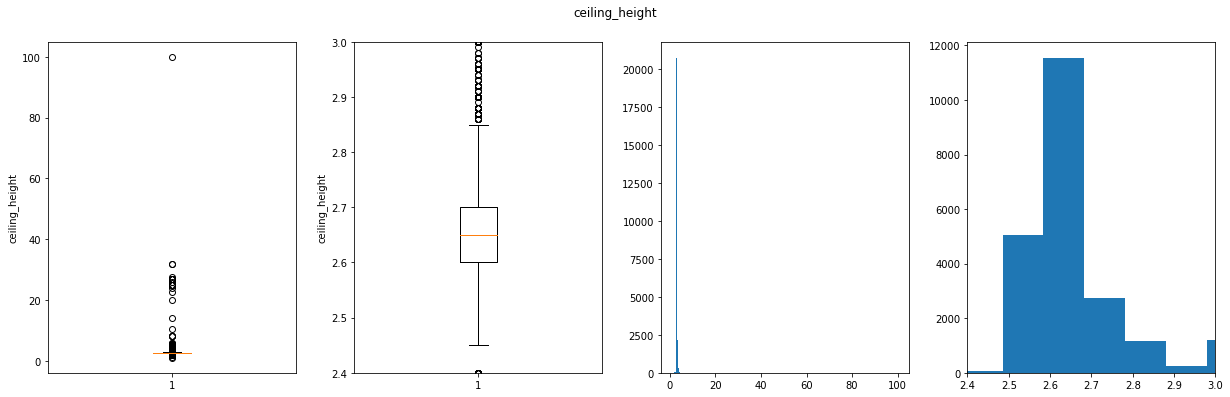

Min: 1.00
Mean: 2.72
Max: 100.00
Mode: [2.6500001 2.5       2.5999999]
1st percentile: 2.50
25th percentile: 2.60
Median: 2.65
75th percentile: 2.70
99th percentile: 3.60
Interquartile range (IQR): 0.10


In [ ]:
# Анализ 'ceiling_height'

analyze_param('ceiling_height', bins1 = 200, bins2 = 1000)

Значения высоты потолков распределены преимущественно в диапазоне 2,5м. - 3,6м.. со средним значением 2,72м. и медианным 2,65м. Есть выбросы с очень большими значениями (около 30м. и 100м.), а так же с очень маленьким (1м.). Значения высоты потолка в районе 30м возможно связаны с ошибками ввода данных, когда вместо 2,7м. ввели 27м. Выбросы 1м. и 100м. нужно удалить.

In [ ]:
df.query('20 < ceiling_height < 40')[['ceiling_height', 'total_area', 'floors_total', 'floor']]

,ceiling_height,total_area,floors_total,floor
351,25.0,55.200001,5,2
3120,32.0,75.000000,3,2
4602,25.0,45.000000,9,2
4832,27.0,25.000000,25,17
5030,24.0,30.500000,5,1
5198,27.0,54.000000,5,3
5617,26.0,50.000000,9,3
5753,27.0,80.000000,36,13
6186,25.0,44.400002,5,5
9293,25.0,42.000000,5,2


Как видно, это обычные квартиры в многоэтажных домах. Все цифры очень похожи на высоту потолка, но на порядок выше.
Единственное подозрительное значение 22,6 - скорее всего результат опечатки. Заменим его на медианное. 

In [ ]:
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] != 22.6, ceiling_median)
df['ceiling_height'] = df.apply(lambda row: row['ceiling_height']/10 if 20 < row['ceiling_height'] < 40 else row['ceiling_height'], axis = 1)          
df = df.drop(df[df['ceiling_height'] == 100].index).reset_index(drop = True)
df = df.drop(df[df['ceiling_height'] <= 2].index).reset_index(drop = True)
df = df.drop(df[df['ceiling_height'] > 10].index).reset_index(drop = True)

In [ ]:
df.query('ceiling_height >5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ceiling_to_median,kitchen_to_median,days_calculated,meter_price,year,month,weekday,floor_group,living_total_ratio,kitchen_total_ratio
459,15,66571000.0,280.299988,2015-06-11,6,5.2,8,159.500000,7,False,...,False,False,False,237499.125000,2015,6,3,3,0.569033,0.075276
1014,20,155000000.0,310.000000,2018-10-12,5,5.3,3,190.000000,3,False,...,False,False,True,500000.000000,2018,10,4,2,0.612903,0.203226
1374,20,59800000.0,399.000000,2015-01-21,5,5.6,6,226.576096,6,False,...,False,True,False,149874.687500,2015,1,2,2,0.567860,0.172414
3442,3,1400000.0,30.000000,2018-03-16,1,8.0,5,15.300000,2,False,...,False,False,False,46666.671875,2018,3,4,3,0.510000,0.243333
5803,20,5650000.0,45.000000,2018-08-15,1,8.3,16,19.299999,14,False,...,False,False,False,125555.546875,2018,8,2,3,0.428889,0.184444
7506,17,38000000.0,143.000000,2017-11-02,3,5.5,5,83.000000,5,False,...,False,False,True,265734.281250,2017,11,3,2,0.580420,0.202797
12499,14,3900000.0,50.000000,2018-03-29,1,5.3,5,28.392996,5,False,...,False,True,False,78000.000000,2018,3,3,2,0.567860,0.172414
15586,14,5600000.0,67.000000,2016-11-11,3,8.0,16,41.000000,1,False,...,False,False,False,83582.078125,2016,11,4,1,0.611940,0.119403
17267,0,5350000.0,54.000000,2015-06-16,2,8.0,5,29.000000,2,False,...,False,True,False,99074.070312,2015,6,1,3,0.537037,0.172414
20053,17,119000000.0,187.600006,2017-07-10,4,6.0,7,147.000000,7,False,...,False,False,False,634328.312500,2017,7,0,2,0.783582,0.083156


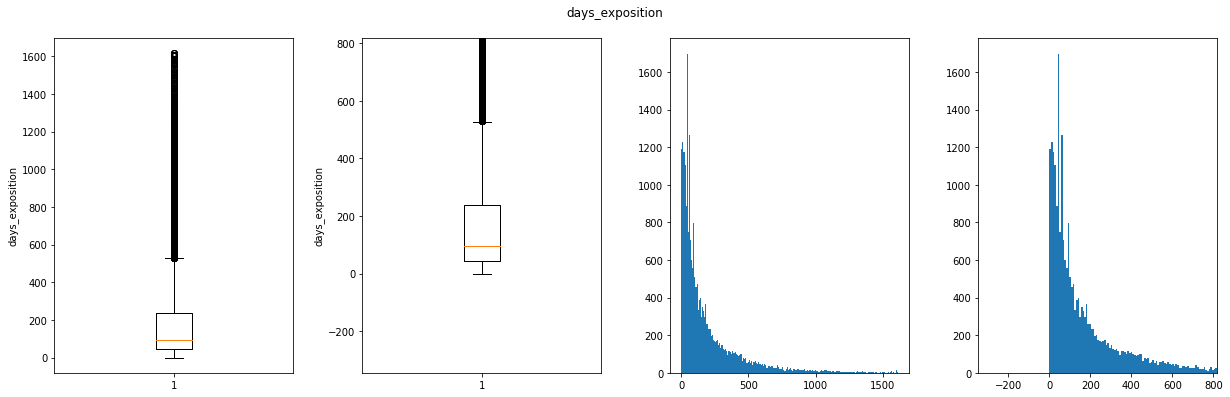

Min: 0.00
Mean: 185.93
Max: 1618.00
Mode: [45 60  7]
1st percentile: 3.00
25th percentile: 43.00
Median: 94.00
75th percentile: 237.00
99th percentile: 1134.58
Interquartile range (IQR): 194.00


In [ ]:
# Анализ 'days_exposition'

analyze_param('days_exposition', bins1 = 200, bins2 = 200)

Значения времени публикации распределены преимущественно в диапазоне 3 - 1134 дней со средним значением 186 дней и медианным 94 дня. Распределение достаточно равномерное с наиболее часто встречающимися значениями 45, 60 и 7 дней. Можно сказать, что квартиры проданные быстрее, чем за 43 дня (1й квартиль) - область достаточно быстрых продаж. При этом мода 7 дней означает, что многие квартиры продаются быстрее и очень быстрыми можно признать продажи в течении трех дней (1-й персентиль). Срок размещения объявления больше 237 дней (последний квартиль) говорит о долгой продаже, а значения больше 1134 дней - экстремально большие. Помотрим, с чем связано нулевые значения days_exposition.

In [ ]:
df.query('days_exposition == 0')[['days_exposition', 'first_day_exposition']]

,days_exposition,first_day_exposition
2159,0,2019-05-03
3223,0,2019-05-03
4408,0,2019-05-03
5924,0,2019-05-03
8091,0,2019-05-03
9126,0,2019-05-03
10804,0,2019-05-03
11881,0,2019-05-03
12083,0,2019-05-03
12218,0,2019-05-03


Нулевое значение времени публикации объявления соответствует последней дате публикации, которую мы определили ранее. Посмотрим, насколько количество публикаций в последний день соответствует данным за другие дни.

In [ ]:
df.groupby(by = 'first_day_exposition')['last_price'].count().tail(10)

first_day_exposition
2019-04-24    33
2019-04-25    28
2019-04-26    37
2019-04-27    14
2019-04-28    18
2019-04-29    37
2019-04-30    27
2019-05-01    30
2019-05-02    11
2019-05-03    20
Name: last_price, dtype: int64

Данные выглядят вполне правдоподобными. Однако, стоит иметь ввиду, что это не означает продажу квартиры за день. Для анализа зависимости цены от срока размещения объявления стоит оценить с какого количества дней можно считать разумным срок продажи квартиры. Для этого посмотрим первые несколько значений.

In [ ]:
days_group = pd.pivot_table(df, values = 'last_price', index = 'days_exposition', aggfunc = ['count','sum'])
days_group.head(10)

,count,sum
,last_price,last_price
days_exposition,,
0,20,1.054600e+08
1,12,1.165441e+08
2,32,2.733339e+08
3,179,9.677624e+08
4,209,1.181421e+09
5,170,1.098206e+09
6,137,6.327891e+08
7,267,1.431487e+09


Начиная с четвертого дня размещения количество и цена проданных квартир становится достаточно стабильным. Записи за последние 4 дня с числом days_exposition меньше 4 можно удалить

In [ ]:
print('Количество записей до удаления :',df.shape[0])

Количество записей до удаления : 23443


In [ ]:
df = df.drop(df[(df['first_day_exposition'] >= '2019-04-30') & (df['days_exposition'] <= 4)].index).reset_index(drop = True)
print('Количество записей после удаления :',df.shape[0])

Количество записей после удаления : 23355


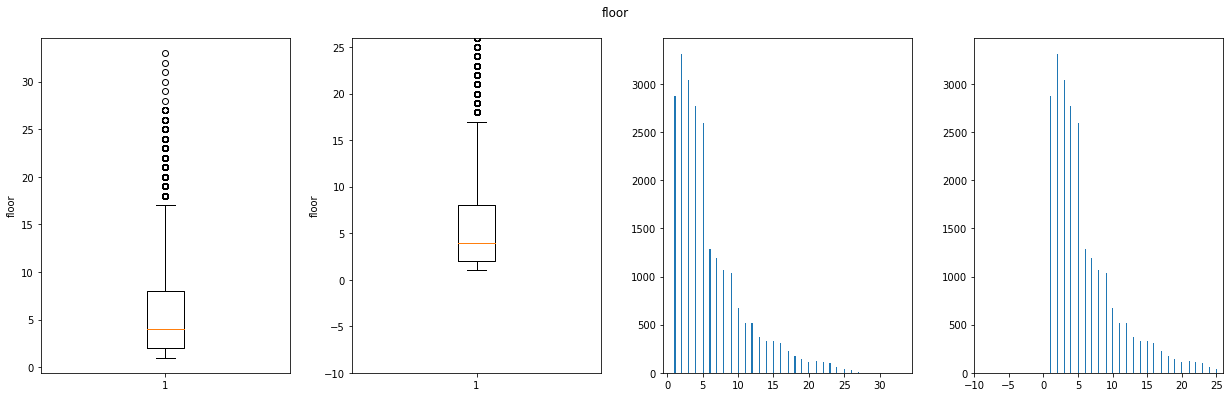

Min: 1.00
Mean: 5.88
Max: 33.00
Mode: [2 3 1]
1st percentile: 1.00
25th percentile: 2.00
Median: 4.00
75th percentile: 8.00
99th percentile: 23.00
Interquartile range (IQR): 6.00


In [ ]:
# Анализ 'floor'

analyze_param('floor', bins1 = 200, bins2 = 200)

Значения номера этажа распределены преимущественно в диапазоне 1 - 23 со средним значением 5,88 и медианным 4. Распределение логично сдвинуто влево и не имеет выбросов.


По результатам анализа интересующих нас параметров мы сократили датасет за счет удаления выбросов и аномалий с 23565 до 23358 строк, что составляет менее 1% данных.

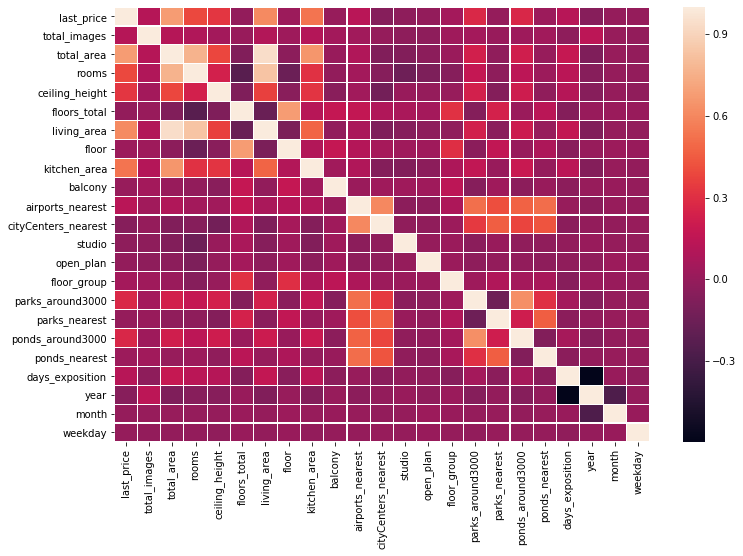

In [ ]:
# Исследуем от чего зависит цена квартиры

columns_hm = ['last_price', 'total_images', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'studio', 'open_plan', 'floor_group',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'year', 'month',
       'weekday']
df_hm = df[columns_hm]
_, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hm.corr(), fmt="d", linewidths=.1, ax=ax)
plt.show()


In [ ]:
df_hm.corr()['last_price']

last_price             1.000000
total_images           0.119443
total_area             0.678839
rooms                  0.388997
ceiling_height         0.329066
floors_total          -0.007686
living_area            0.609969
floor                  0.022845
kitchen_area           0.534618
balcony                0.007437
airports_nearest       0.129835
cityCenters_nearest   -0.055524
studio                -0.028327
open_plan             -0.009645
floor_group            0.057572
parks_around3000       0.272988
parks_nearest          0.000651
ponds_around3000       0.266237
ponds_nearest          0.025943
days_exposition        0.121015
year                  -0.050376
month                 -0.002545
weekday                0.000249
Name: last_price, dtype: float64

Из heatmap и расчитанных коэффициентов корелляции видно, что цена квартиры достаточно сильно зависит от параметров площади помещения ("total_area", "living_area", "kitchen_area"). Меньше на цену влияют количество комнат, высота потолков, расстояние до центра города и количество парков и водоемов поблизости. Остальные критерии влияют на стоимость квартир незначительно.

Изучим влияние этажа на стоимость квартиры

In [ ]:
df['last_price'].corr(df['floor_group'])

0.057572459401763657

Зависимость цены квартиры от этажа выглядит незначительной, с коэффициентом корелляции менее 0,06.


Посмотрим, как зависит цена от даты размещения объявления

In [ ]:
df_weekday_group = df.groupby('weekday')['last_price'].mean().sort_values(ascending = True)
print('Средняя цена по дням недели', df_weekday_group)

Средняя цена по дням недели weekday
6    6266920.0
1    6339142.0
4    6371820.5
2    6417569.5
0    6425934.5
5    6485134.0
3    6674585.5
Name: last_price, dtype: float32


In [ ]:
df_month_group = df.groupby('month')['last_price'].mean().sort_values(ascending = True)
print('Средняя цена по месяцам', df_month_group)

Средняя цена по месяцам month
10    6213253.0
6     6267845.0
3     6304971.0
5     6349246.5
8     6367003.0
11    6433163.5
2     6434675.0
9     6463673.5
12    6536697.5
1     6586895.5
7     6647217.5
4     6692478.5
Name: last_price, dtype: float32


In [ ]:
df_year_group = df.groupby('year')['last_price'].mean().sort_values(ascending = True)
print('Средняя цена по годам', df_year_group)

Средняя цена по годам year
2018     5965129.0
2017     6358768.5
2019     6649627.5
2016     6776120.0
2015     8490267.0
2014    12046600.0
Name: last_price, dtype: float32


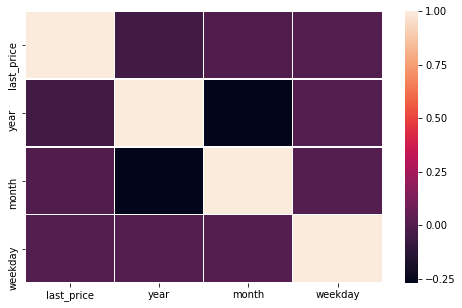

In [ ]:
df_date_group = df[['last_price', 'year', 'month', 'weekday']]

_, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df_date_group.corr(), fmt="d", linewidths=.1, ax=ax)
plt.show()

Никакой явной зависимости цены квартиры от дня, месяца или года публикации нет.


Изучим, как распределены объявления по населенным пунктам

In [ ]:
df_location_amount_group = df.groupby('locality_name')['last_price'].count().sort_values(ascending = False).head(10)
loc_amount_stat = df_location_amount_group.index
print('Наибольшее число объявлений по населенным пунктам :', df_location_amount_group)

Наибольшее число объявлений по населенным пунктам : locality_name
Санкт-Петербург      15505
посёлок Мурино         515
посёлок Шушары         437
Всеволожск             395
Пушкин                 365
Колпино                337
посёлок Парголово      327
Гатчина                305
деревня Кудрово        297
Выборг                 234
Name: last_price, dtype: int64


In [ ]:
df_location_price_group = df[df['locality_name'].isin(loc_amount_stat)].groupby('locality_name')['meter_price'].mean().sort_values(ascending = False)
print('Средняя цена квадратного метра жилья по населенным пунктам :', df_location_price_group.round(2))

Средняя цена квадратного метра жилья по населенным пунктам : locality_name
Санкт-Петербург      114445.320312
Пушкин               102946.789062
деревня Кудрово       92472.203125
посёлок Парголово     90175.906250
посёлок Мурино        85503.117188
посёлок Шушары        78554.921875
Колпино               75420.656250
Всеволожск            68816.343750
Гатчина               68811.937500
Выборг                58191.160156
Name: meter_price, dtype: float32


In [ ]:
df_location_group_result = pd.concat([df_location_amount_group, df_location_price_group], axis = 1)
df_location_group_result.columns = ['number_of_ads', 'meter_price']
df_location_group_result.sort_values('number_of_ads', ascending = False)

,number_of_ads,meter_price
Санкт-Петербург,15505,114445.320312
посёлок Мурино,515,85503.125000
посёлок Шушары,437,78554.914062
Всеволожск,395,68816.343750
Пушкин,365,102946.789062
Колпино,337,75420.664062
посёлок Парголово,327,90175.914062
Гатчина,305,68811.937500
деревня Кудрово,297,92472.195312
Выборг,234,58191.164062


Cамая высокая средняя стоимость квадратного метра (около 115 тысяч) предсказуемо выявлена в Санкт-Петербурге. 
Самая низкая, почти в два раза ниже - в Выборге.

Рассмотрим подробнее рынок недвижимости Санкт-Петербурга. Определим как влияет на цену расстояние до центра города.

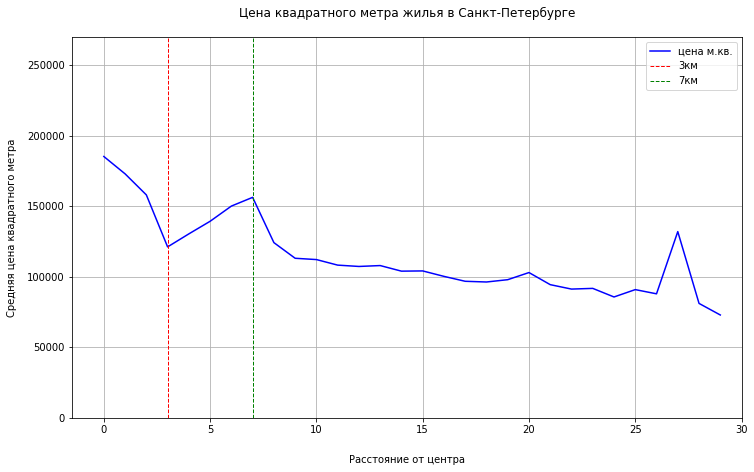

In [ ]:
df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb['cityCenter_km'] = round(df_spb['cityCenters_nearest']/1000)
df_spb_stat = df_spb.pivot_table(index = 'cityCenter_km', values = 'meter_price', aggfunc = ['mean'])

# Отобразим на графике изменение средней цены квадратного метра недвижимости при удалении от центра Санкт-Петербурга

fig, ax = plt.subplots(figsize = (12,7))
ax.plot(df_spb_stat, '-b', label='цена м.кв.')
ax.plot([3, 3], [0, 270000], color='r', linestyle='--', linewidth=1 , label = '3км')
ax.plot([7, 7], [0, 270000], color='g', linestyle='--', linewidth=1 , label = '7км')
ax.set_title('Цена квадратного метра жилья в Санкт-Петербурге', pad = 20)
ax.set_xlabel('Расстояние от центра', labelpad = 20)
ax.set_ylabel('Средняя цена квадратного метра', labelpad = 10)
ax.grid(True)
ax.set(xlim = (-1.5, 30), ylim= (0,270000))
leg = ax.legend();
plt.show()

Из графика видно, что средняя цена квадратного метра изменяется неравномерно при удалении от центра города. Сначала цена резко падает примерно до 125000, но потом на расстоянии с 3 до 7 км она поднимается до 150000. Поле этого график плавно идет вниз. Такое поведение цены можно объяснить географическими особенностями Санкт-Петербурга. Первая область в радиусе 3 км - исторический центр города с самой дорогой недвижимостью. Ее с трех сторон окружает Нева и обводной канал. Рост цен в области 3 -7 км от центра связана с тем, что там находятся некоторые популярные районы города, например Васильевский остров и Петроградский район. Однако, это скорее исключения, пэтому центр города стоит ограницить областью 3км.


Изучим подробнее данные о квартирах в ценральной части Санкт-Петербурга.


In [ ]:
df_spb_center = df_spb.query('cityCenter_km <= 3')
df_spb_center.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_to_median,days_calculated,meter_price,year,month,weekday,floor_group,living_total_ratio,kitchen_total_ratio,cityCenter_km
24,8,6500000.0,97.199997,2015-10-31,2,2.65,3,46.500000,1,False,...,False,False,66872.429688,2015,10,5,1,0.478395,0.201646,2.0
81,9,10949000.0,68.000000,2018-12-27,1,2.65,10,38.614471,6,False,...,True,True,161014.703125,2018,12,3,3,0.567860,0.172414,-0.0
99,32,9600000.0,90.000000,2017-09-26,4,2.65,5,67.000000,2,False,...,False,False,106666.656250,2017,9,1,3,0.744444,0.088889,3.0
137,8,4800000.0,40.000000,2017-11-18,2,2.65,3,29.000000,2,False,...,False,False,120000.000000,2017,11,5,3,0.725000,0.150000,3.0
153,1,8200000.0,80.000000,2018-11-06,3,4.15,3,44.200001,2,False,...,False,False,102500.000000,2018,11,1,3,0.552500,0.152500,3.0


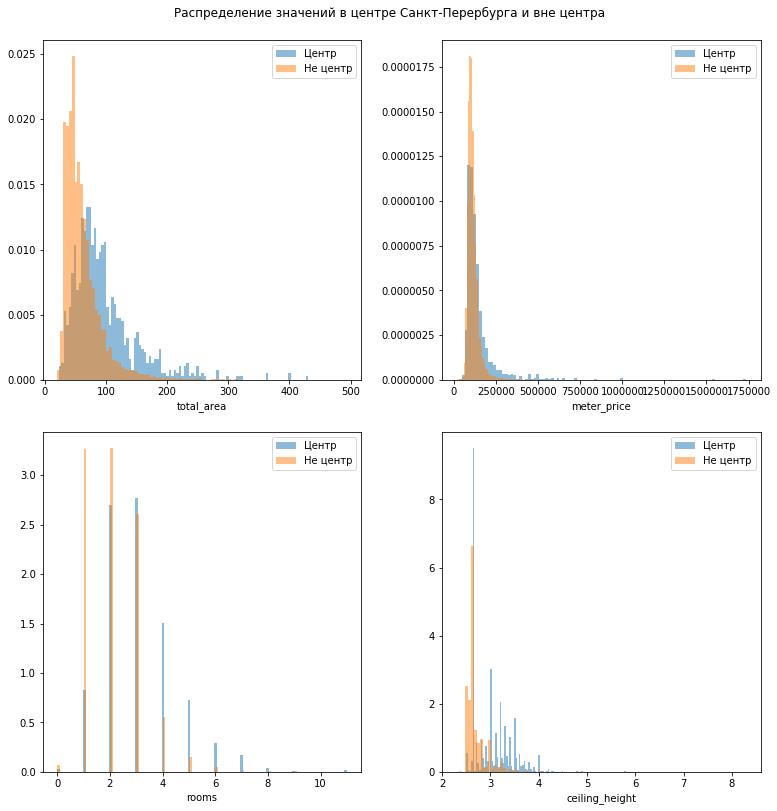

			Центр СПб : 

        total_area   meter_price       rooms  ceiling_height
count  924.000000  9.240000e+02  924.000000      924.000000
mean    97.360237  1.499969e+05    3.054113        3.031115
std     53.617996  1.215359e+05    1.430701        0.406709
min     22.700001  2.891963e+04    0.000000        2.500000
25%     63.000000  9.680074e+04    2.000000        2.650000
50%     83.649998  1.175484e+05    3.000000        3.000000
75%    115.475002  1.527941e+05    4.000000        3.300000
max    431.000000  1.736842e+06   11.000000        5.800000

			За пределами центра СПб : 

          total_area    meter_price         rooms  ceiling_height
count  14581.000000   14581.000000  14581.000000    14581.000000
mean      62.314545  112192.406250      2.112407        2.704383
std       35.199543   40327.875000      1.065443        0.228077
min       20.100000   15345.269531      0.000000        2.300000
25%       41.299999   90643.273438      1.000000        2.600000
50%       54.000000

In [ ]:
columns_to_analyze = ['total_area', 'meter_price', 'rooms', 'ceiling_height']
df_spb_not_center = df_spb.query('cityCenter_km > 3')


fig, axs = plt.subplots(2, 2, figsize = (12,12))
axs = axs.ravel()
for i, column in enumerate(columns_to_analyze):

    axs[i].hist(df_spb_center[column], bins = 100, density=True, alpha = 0.5, label='Центр')
    axs[i].hist(df_spb_not_center[column], bins = 100, density=True, alpha = 0.5, label='Не центр')
    axs[i].set_xlabel(column)
    axs[i].legend() 
plt.tight_layout(pad=5, w_pad=2, h_pad=2)
plt.suptitle('Распределение значений в центре Санкт-Перербурга и вне центра')
plt.show()

print('\t\t\tЦентр СПб : \n\n', df_spb_center[columns_to_analyze].describe())
print('\n\t\t\tЗа пределами центра СПб : \n\n', df_spb_not_center[columns_to_analyze].describe())

Из гистограмм плотности распределения значений площади, цены, количества комнат и высоты потолков мы отчетливо видим различие квартир в центре города и за его пределами.

 - Квартиры в центре больше по площади (почти 100м.кв в среднем) по сравнению с 62м.кв. у квартир на окраине
 - Средняя цена квадратного метра в центре города также выше (150 тысяч против 112 тысяч)
 - Распределение количества комнат в квартирах в центральной части Санкт-Петербурга смещено в сторону больших значений по сравнению с квартирами в других районах. Средние значения 3.1 и 2.1 соответственно.
 - Средняя высота потолков в центральной части города больше, чем за ее пределами. Медианное значение в обоих случаях 2,65м.
 
 Кроме того, разброс значений у квартир в центре как правило меньше, чем в остальном городе, что говорит о его достаточной гомогенности.

### Общий вывод

Удалось определить ключевые параметры для автоматической системы контроля релевантности данных. Рассмотренные факторы по-разному влияют на цену квартиры. Наиболее важные параметры связаны с площадью помещения, а также с высотой потолков и количеством комнат. Этаж квартиры, наоборот, практически не влияет на стоимость жилья. Какой-либо сезонности или зависимости от дня публикации объявления не обнаружено.

Коэффициенты корелляции цен на квартиры и других параметров в порядке убывания:  

|Параметр|Коэффициент корелляции|
|:----|:----|
|Общая площадь|0.678839|
|Жилая площадь|0.609969|
|Площадь кухни|0.534618|
|Количетво комнат|0.388997| 
|Высота потолков|0.329066|

Проведен анализ цен на квартиры в разных населенных пунктах. Cамая высокая средняя стоимость квадратного метра (около 115 тысяч) - в Санкт-Петербурге. Самая низкая (58 тысяч) - в Выборге.

Также был проведен анализ центральной части Санкт-Петербурга. Из графика изменения цены от расстояния до центра города мы определили, что центральная область, существенно отличающаяся по цене от остальных районов города находится в радиусе 3 км от центра. Сравнение гистограмм плотности распределений значений площади, цены, количества комнат и высоты потолков квартир в центре города и за его пределами показало значительное превышение этих параметров в центре.

В ходе анализа было обнаружено больше 23% пропущенных значений в автоматически генерируемых данных о расположении объекта недвижимости, предположительно из-за отсутствия координат. Стоит восполнять эти пропуски из других баз по адресу квартиры.

Необходимо ограничить диапазон допустимых значений при вводе высоты потолков так, чтобы ошибки ввода не портили данные. Для квартир-ситудий можно ограничить возможность ввода нулевого количества комнат.

В целом, качество датасета хорошее. После обработки пропущенных данных, анализа распределения значений по ключевым параметрам и очистки данных от выбросов, датасет оскратился меньше чем на 1,5%. Дубликатов в данных нет.